In [2]:
import torch
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt

数据集加载

In [ ]:
data_path = "./data"
# 加载训练集和测试集，将图片转换为tensor
train_data = tv.datasets.FashionMNIST(
    root=data_path, train=True, download=True, transform=tv.transforms.ToTensor()
)
test_data = tv.datasets.FashionMNIST(
    root=data_path, train=False, download=True, transform=tv.transforms.ToTensor()
)
# 创建数据迭代器
batch_size = 256
train_iter = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=0
)
test_iter = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=0
)

In [ ]:
for imgs, labs in train_iter:
    print(imgs.shape)
    print(labs.shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256])


可视化数据集

In [ ]:
def get_fashion_label(label):
    text_labels = [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]
    return text_labels[label]

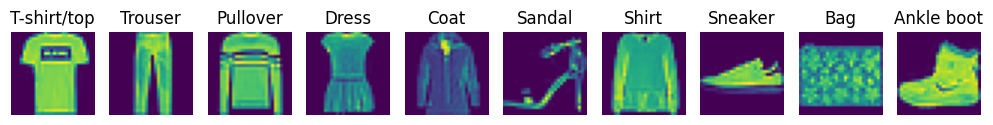

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 5))
for i in range(10):
    idx = (train_data.targets == i).nonzero()[0].item()
    img, label = train_data[idx]
    axes[i].imshow(img.view(28, 28))
    axes[i].set_title(get_fashion_label(label))
    axes[i].axis("off")
plt.tight_layout()
plt.show()

初始化模型参数

In [ ]:
num_inputs = 784
num_outputs = 10
# 由于transforms.ToTensor()将图片转换成torch.float32类型，所以模型参数的数据类型也要统一
w = torch.normal(mean=0, std=0.01, size=(num_inputs, num_outputs))
b = torch.ones(num_outputs)

(tensor([[-0.0067, -0.0123, -0.0016,  ..., -0.0049, -0.0209,  0.0104],
         [-0.0089, -0.0068,  0.0089,  ..., -0.0015,  0.0043,  0.0119],
         [-0.0059, -0.0122,  0.0066,  ..., -0.0158,  0.0006,  0.0082],
         ...,
         [-0.0017, -0.0021, -0.0073,  ...,  0.0060,  0.0107, -0.0038],
         [-0.0100, -0.0054,  0.0018,  ..., -0.0080,  0.0032, -0.0165],
         [ 0.0164, -0.0110, -0.0006,  ..., -0.0017, -0.0012, -0.0044]]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [22]:
def softmax(pred: torch.Tensor):
    """
    Args:
        x: batch_size*10
    """
    sum_ = torch.sum(torch.exp(pred), dim=1, keepdim=True)
    return torch.exp(pred) / sum_

def net(x: torch.Tensor):
    """
    x: batch_size*1*28*28的四维矩阵,首先要转换形状,再做线性变换
    """
    return softmax(torch.matmul(x.reshape((-1,)), w) + b)

实现softmax回归

In [ ]:
# torch.gather()函数学习
# 输出结果为二维矩阵

tensor([[1, 2, 3],
        [4, 6, 5]])
tensor([[1, 5, 9],
        [1, 8, 6]])


损失函数和优化函数

In [ ]:
def loss_function(pred_y: torch.Tensor, true_y: torch.Tensor):
    """交叉熵损失函数"""
    return -(true_y * pred_y.log()).sum()


def sgd(params, learning_rate, batch_size):
    for param in params:
        param.data -= learning_rate * param.grad / batch_size

开始模型训练

In [ ]:
learning_rate = 0.1  # 收敛速度慢，尝试增大学习率
epochs = 40
train_acc, test_acc = [], []
train_loss, test_loss = [], []
for e in range(epochs):
    train_loss_sum = 0
    train_acc_sum = 0
    train_length = 0
    for imgs, labels in train_iter:
        pred_y = net(imgs)
        los = loss_function(pred_y, labels).sum()
        los.backward()
        sgd([w, b], learning_rate, batch_size)
        train_loss_sum += los.item()
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
        pred_true = (
            (pred_y.argmax(dim=1) == labels).sum().item()
        )  # argmax()输出结果为一维，每一行最大值的索引即预测类的索引值
        train_acc_sum += pred_true
        train_length += labels.shape[0]
    train_acc.append(train_acc_sum / train_length)
    train_loss.append(train_loss_sum / train_length)
    # 测试集预测
    test_loss_sum, test_acc_sum, test_length = 0, 0, 0
    for pred, y in test_iter:
        pred = net(pred)
        tlos = loss_function(pred, y).sum()
        test_loss_sum += tlos.item()
        pre = (pred.argmax(dim=1) == y).sum().item()
        test_acc_sum += pre
        test_length += y.shape[0]
    test_loss.append(test_loss_sum / test_length)
    test_acc.append(test_acc_sum / test_length)
    print(
        "epoch %d, loss %.3f, train acc %.3f, test acc %.3f"
        % (e + 1, train_loss[e], train_acc[e], test_acc[e])
    )

epoch 1, loss 0.787, train acc 0.747, test acc 0.793
epoch 2, loss 0.571, train acc 0.813, test acc 0.813
epoch 3, loss 0.525, train acc 0.826, test acc 0.818
epoch 4, loss 0.502, train acc 0.831, test acc 0.825
epoch 5, loss 0.486, train acc 0.837, test acc 0.827
epoch 6, loss 0.474, train acc 0.840, test acc 0.829
epoch 7, loss 0.465, train acc 0.843, test acc 0.828
epoch 8, loss 0.458, train acc 0.845, test acc 0.827
epoch 9, loss 0.453, train acc 0.846, test acc 0.835
epoch 10, loss 0.447, train acc 0.848, test acc 0.831
epoch 11, loss 0.444, train acc 0.849, test acc 0.834
epoch 12, loss 0.440, train acc 0.850, test acc 0.836
epoch 13, loss 0.436, train acc 0.851, test acc 0.837
epoch 14, loss 0.433, train acc 0.852, test acc 0.836
epoch 15, loss 0.431, train acc 0.853, test acc 0.835
epoch 16, loss 0.428, train acc 0.854, test acc 0.835
epoch 17, loss 0.426, train acc 0.855, test acc 0.835
epoch 18, loss 0.424, train acc 0.855, test acc 0.839
epoch 19, loss 0.422, train acc 0.856

可视化模型的训练效果

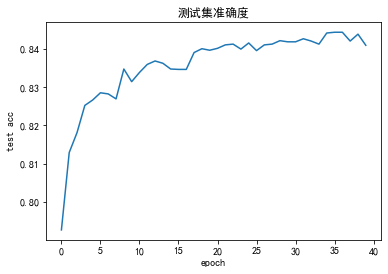

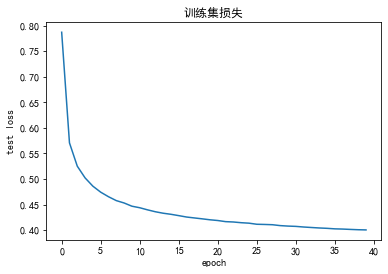

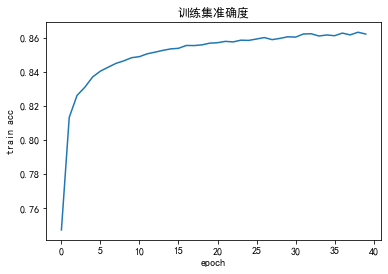

In [ ]:
# 解决中文乱码
plt.rcParams["font.sans-serif"] = ["SimHei"]

plt.plot(range(epochs), test_acc)
plt.xlabel("epoch")
plt.ylabel("test acc")
plt.title("测试集准确度")
plt.show()

plt.plot(range(epochs), train_loss)
plt.xlabel("epoch")
plt.ylabel("test loss")
plt.title("训练集损失")
plt.show()

plt.plot(range(epochs), train_acc)
plt.xlabel("epoch")
plt.ylabel("train acc")
plt.title("训练集准确度")
plt.show()

实验结果分析

据可视化的实验结果，模型在训练集上的损失逐渐降低，准确度逐渐升高。虽然模型在测试集的准确度曲线有明显波动，中途会有下降，但总体还是呈上升趋势，最终趋于稳定。